In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from gensim.models import Word2Vec
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.metrics import mean_squared_error
from collections import Counter
import textwrap
import bitsandbytes
import torch
from transformers import pipeline
from transformers.utils import logging

logging.set_verbosity_error()


bin c:\NLP\Final-project\Project3\.venv\lib\site-packages\bitsandbytes\libbitsandbytes_cpu.so
function 'cadam32bit_grad_fp32' not found


c:\NLP\Final-project\Project3\.venv\lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
c:\NLP\Final-project\Project3\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
articles_df = pd.read_csv('scopus_articles_data.csv')
articles_df.head()

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Link,Abstract,Author Keywords,Index Keywords
0,Shankar V.; Parsana S.,"Shankar, Venkatesh (7102439832); Parsana, Sohi...",7102439832; 57200450074,An overview and empirical comparison of natura...,2022,Journal of the Academy of Marketing Science,https://www.scopus.com/inward/record.uri?eid=2...,With artificial intelligence permeating conver...,Artificial intelligence; Autoencoder; Machine ...,NaN
1,Chen K.; Meng Y.; Sun X.; Guo S.; Zhang T.; Li...,"Chen, Kangjie (57219735841); Meng, Yuxian (572...",57219735841; 57216617236; 57216611212; 5683490...,BADPRE: TASK-AGNOSTIC BACKDOOR ATTACKS TO PRE-...,2022,ICLR 2022 - 10th International Conference on L...,https://www.scopus.com/inward/record.uri?eid=2...,Pre-trained Natural Language Processing (NLP) ...,NaN,Backdoors; Down-stream; Foundation models; Key...
2,Hemavathi U.; Medona A.C.V.,"Hemavathi, U. (57226555469); Medona, Ann C. V....",57226555469; 57226547686,AI-Based Interactive Agent for Health Care Usi...,2022,Lecture Notes in Networks and Systems,https://www.scopus.com/inward/record.uri?eid=2...,Artificial intelligence (AI)-based interactive...,Artificial intelligence; Deep learning; Health...,NaN
3,Bauer D.; Longley T.; Ma Y.; Wilson T.,"Bauer, Daniel (57197925699); Longley, Tom (574...",57197925699; 57425276200; 57286065200; 5805552...,NLP in Human Rights Research: Extracting Knowl...,2022,Proceedings of the 16th Linguistic Annotation ...,https://www.scopus.com/inward/record.uri?eid=2...,In this paper we explore the use of an NLP sys...,Applications; Ethics and Legal Issues; Informa...,Data mining; Knowledge graph; Law enforcement;...
4,Gessler L.,"Gessler, Luke (57219184334)",57219184334,Closing the NLP Gap: Documentary Linguistics a...,2022,COMPUTEL 2022 - 5th Workshop on the Use of Com...,https://www.scopus.com/inward/record.uri?eid=2...,"For decades, researchers in natural language p...",NaN,Application programs; Computational linguistic...


In [3]:
abstracts = articles_df['Abstract'].dropna().tolist()

In [4]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger"])

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 3.1 MB/s eta 0:00:04
     ------ --------------------------------- 2.1/12.8 MB 3.9 MB/s eta 0:00:03
     --------- ------------------------------ 2.9/12.8 MB 3.8 MB/s eta 0:00:03
     ---------- ----------------------------- 3.4/12.8 MB 3.7 MB/s eta 0:00:03
     ------------- -------------------------- 4.2/12.8 MB 3.6 MB/s eta 0:00:03
     --------------- ------------------------ 5.0/12.8 MB 3.6 MB/s eta 0:00:03
     ------------------ --------------------- 5.8/12.8 MB 3.6 MB/s eta 0:00:02
     -------------------- ------------------- 6.6/12.8 MB 3.6 MB/s eta 0:00:02
     ---------------------- ----------------- 7.3/12.8 MB 3.6 MB/s eta 0:00:02
     ------------------------- -------------- 8.1/12.8 MB 3.6 MB/s eta 0:00:02
     --------------------------- ------------ 8.9/12.8 MB 3.6 MB/s

2025-07-06 15:22:40.374211: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



In [5]:
def preprocess_texts(texts):
    def process_text(text):
        return ' '.join([
            token.lemma_.lower()
            for token in text
            if not token.is_stop and not token.is_punct and token.lemma_.isalpha()
        ])

    return [process_text(text) for text in nlp.pipe(texts, batch_size=50, n_process=4)]

processed_abstracts = preprocess_texts(abstracts)
print(abstracts[0:5])
print(processed_abstracts[0:5])


['With artificial intelligence permeating conversations and marketing interactions through digital technologies and media, machine learning models, in particular, natural language processing (NLP) models, have surged in popularity for analyzing unstructured data in marketing. Yet, we do not fully understand which NLP models are appropriate for which marketing applications and what insights can be best derived from them. We review different NLP models and their applications in marketing. We layout the advantages and disadvantages of these models and highlight the conditions under which different models are appropriate in the marketing context. We introduce the latest neural autoencoder NLP models, demonstrate these models to analyze new product announcements and news articles, and provide an empirical comparison of the different autoencoder models along with the statistical NLP models. We discuss the insights from the comparison and offer guidelines for researchers. We outline future ex

In [6]:
def create_bar_chart(data, title, xlabel, ylabel):
    plt.figure(figsize=(14, 8)) 

    wrapped_labels = [ '\n'.join(textwrap.wrap(str(label), 15)) for label in data.index ]

    ax = data.plot(kind='bar', color='cornflowerblue', edgecolor='black')

    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    plt.xticks(ticks=range(len(data)), labels=wrapped_labels, rotation=90, ha='center', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for p in ax.patches:
        height = p.get_height()
        if isinstance(height, int) or height.is_integer():
            label = f'{int(height)}'
        else:
            label = f'{height:.3f}'
        ax.annotate(label,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

def create_grouped_bar_chart(indices, group1, group2, title, xlabel, ylabel):
    width = 0.35
    x = np.arange(len(indices))

    fig, ax = plt.subplots(figsize=(14, 8))
    bars1 = ax.bar(x - width/2, group1, width, label='Group 1', color='cornflowerblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, group2, width, label='Group 2', color='lightcoral', edgecolor='black')

    ax.set_title(title, fontsize=18, weight='bold')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(indices, rotation=90, ha='center', fontsize=10)
    ax.legend()

    for bar in bars1 + bars2:
        height = bar.get_height()
        if isinstance(height, int) or height.is_integer():
            label = f'{int(height)}'
        else:
            label = f'{height:.3f}'
        ax.annotate(label,
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

def create_bins_chart(data, title, xlabel, ylabel, bins_number=30):
    plt.hist(data, bins=bins_number, color='skyblue', edgecolor='black')
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.show()
    
def create_wordcloud(scored_tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(scored_tokens)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

[('nlp', 15612), ('language', 6962), ('data', 4948), ('processing', 4437), ('natural', 4283), ('based', 3842), ('models', 3380), ('text', 3232), ('model', 3186), ('learning', 2969), ('research', 2790), ('analysis', 2782), ('paper', 2680), ('information', 2574), ('results', 2537), ('methods', 2224), ('study', 2190), ('system', 2114), ('tasks', 2081), ('techniques', 2031), ('use', 1797), ('approach', 1795), ('performance', 1735), ('machine', 1638), ('method', 1524), ('different', 1471), ('systems', 1458), ('clinical', 1455), ('accuracy', 1417), ('task', 1404), ('proposed', 1327), ('applications', 1321), ('word', 1310), ('work', 1294), ('classification', 1224), ('time', 1221), ('computational', 1194), ('knowledge', 1170), ('process', 1152), ('ieee', 1117), ('new', 1101), ('sentiment', 1095), ('tools', 1073), ('large', 1049), ('human', 1022), ('training', 1020), ('deep', 1006), ('association', 1004), ('semantic', 1000), ('problem', 997), ('domain', 992), ('extraction', 984), ('features', 9

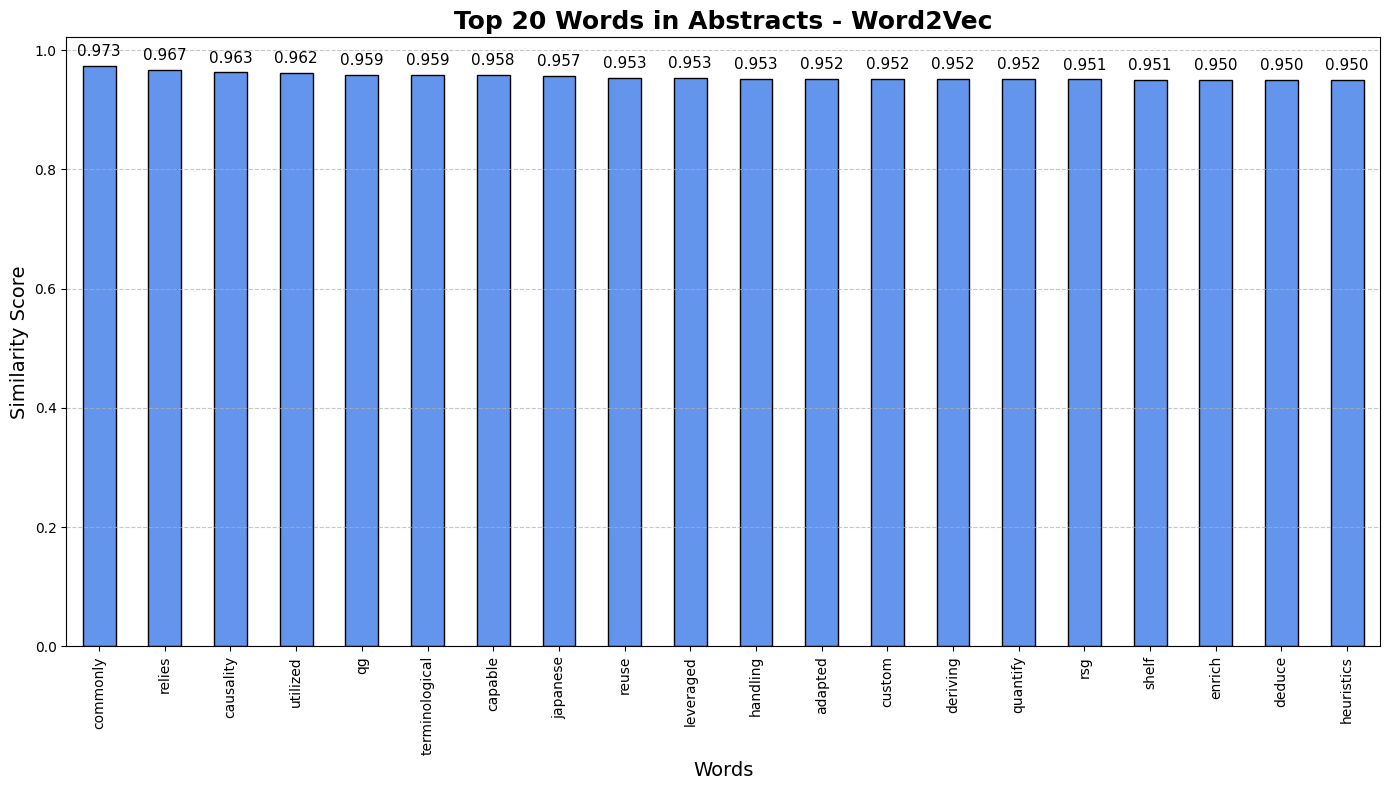

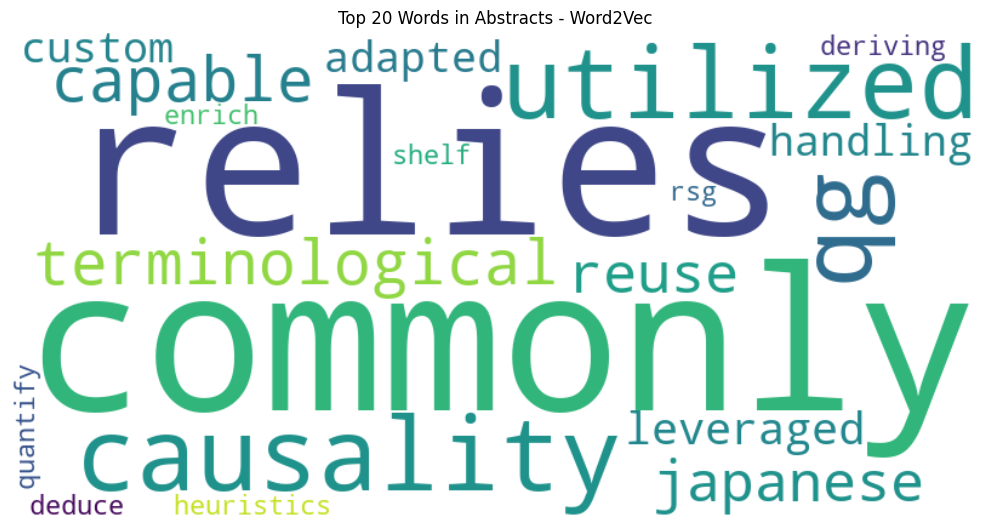

In [7]:
abstracts_splitted_tokens = [text.split() for text in processed_abstracts]
model = Word2Vec(sentences=abstracts_splitted_tokens, vector_size=300, window=7, min_count=3, workers=4)

all_tokens = [token for tokens in abstracts_splitted_tokens for token in tokens if token in model.wv]
mean_vector = sum(model.wv[token] for token in all_tokens) / len(all_tokens)
similar_words = model.wv.similar_by_vector(mean_vector, topn=20)
top_100_words = model.wv.index_to_key[:100]
top_100_words_with_counts = [(word, model.wv.get_vecattr(word, "count")) for word in top_100_words]
print(top_100_words_with_counts)
words, scores = zip(*similar_words)

create_bar_chart(pd.Series(scores, index=words), "Top 20 Words in Abstracts - Word2Vec", "Words", "Similarity Score")
create_wordcloud(dict(similar_words), "Top 20 Words in Abstracts - Word2Vec")


              word     score
14685          nlp  0.044641
12004     language  0.028848
5202          data  0.026594
13805       models  0.022099
21919         text  0.020515
13795        model  0.019902
12140     learning  0.019899
1998         based  0.019892
17177   processing  0.019744
14357      natural  0.019278
938       analysis  0.017820
18600     research  0.017767
10783  information  0.017307
15757        paper  0.016593
21694        tasks  0.016204
21561       system  0.015338
21767   techniques  0.014554
13430      methods  0.014241
18722      results  0.013881
21021        study  0.013112


<Figure size 1400x800 with 0 Axes>

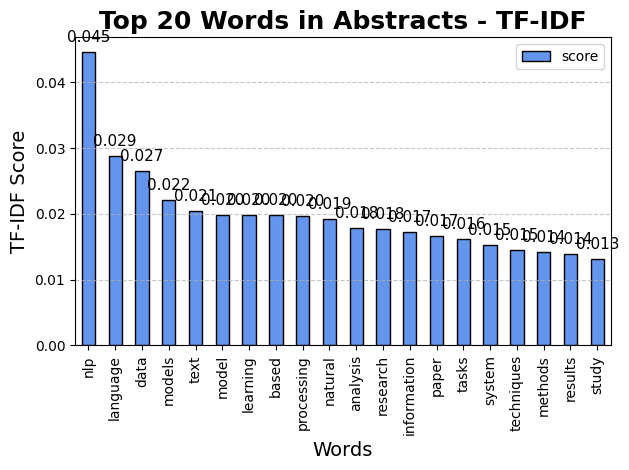

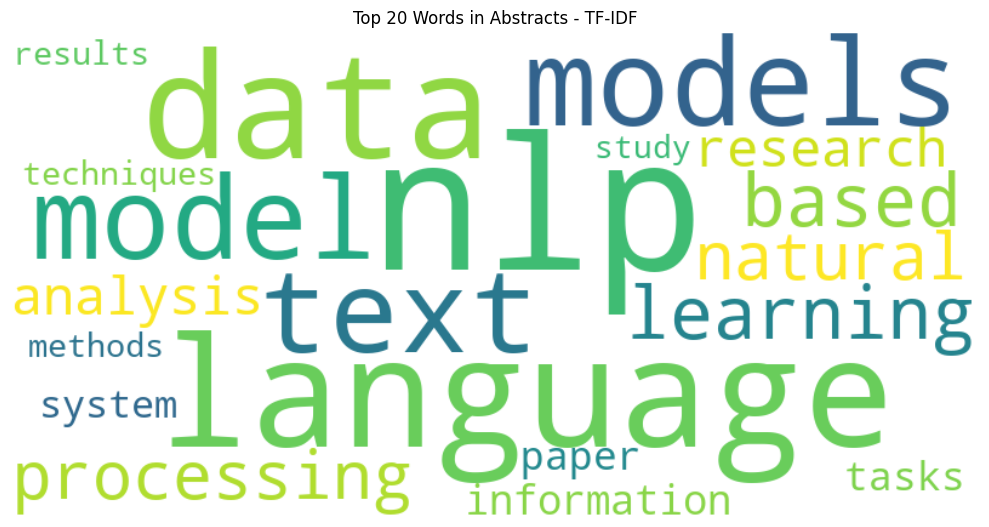

In [8]:

def extract_top_tfidf_words(texts, top_n=20):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(texts)
    tfidf_scores = X.mean(axis=0).A1 
    words = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame({'word': words, 'score': tfidf_scores})
    tfidf_df = tfidf_df.sort_values(by='score', ascending=False).head(top_n)
    return tfidf_df

top_words_df = extract_top_tfidf_words(processed_abstracts)
print(top_words_df)

create_bar_chart(top_words_df.set_index('word'), "Top 20 Words in Abstracts - TF-IDF", "Words", "TF-IDF Score")
create_wordcloud(dict(zip(top_words_df['word'], top_words_df['score'])), "Top 20 Words in Abstracts - TF-IDF")





378/378 [==============================] - 0s 493us/step
Top 20 words with highest reconstruction error:
state: 0.028756
art: 0.015737
neural: 0.007118
processing: 0.006395
artificial: 0.006188
intelligence: 0.005513
health: 0.004900
linguistics: 0.003957
word: 0.003465
results: 0.003453
decision: 0.003386
large: 0.003325
rights: 0.003266
media: 0.003242
et: 0.003127
data: 0.003073
analysis: 0.002985
information: 0.002832
paper: 0.002795
clinical: 0.002735


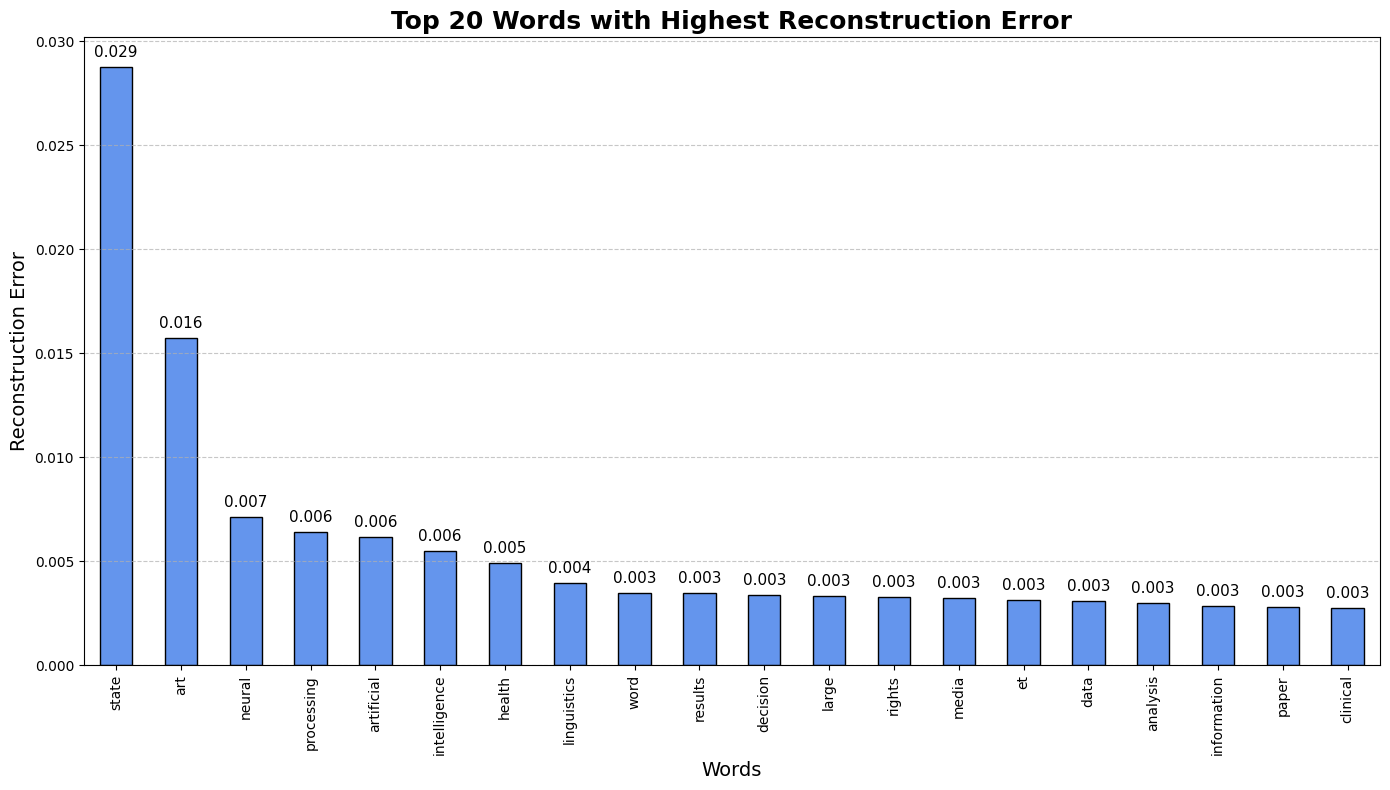

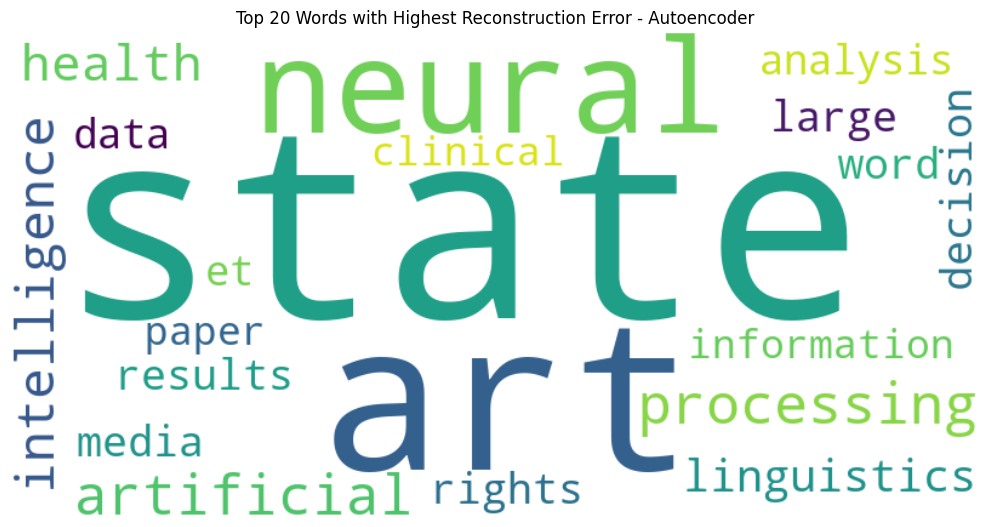

In [9]:

words = model.wv.index_to_key
vectors = np.array([model.wv[word] for word in words])
input_dim = vectors.shape[1]

# the autoencoder gets the Word2Vec vectors as input
input_layer = Input(shape=(input_dim,))
# the encoder compresses the input vectors to a lower dimension
encoded = Dense(128, activation='relu')(input_layer)
# the decoder reconstructs the original vectors from the compressed representation
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(vectors, vectors, epochs=50, batch_size=256, shuffle=True, verbose=0)


predicted_vectors = autoencoder.predict(vectors)
errors = [mean_squared_error(vectors[i], predicted_vectors[i]) for i in range(len(vectors))]
word_errors = list(zip(words, errors))

word_errors_sorted = sorted(word_errors, key=lambda x: x[1], reverse=True)

print(f"Top {20} words with highest reconstruction error:")
for word, error in word_errors_sorted[:20]:
    print(f"{word}: {error:.6f}")
create_bar_chart(pd.Series([error for _, error in word_errors_sorted[:20]], index=[word for word, _ in word_errors_sorted[:20]]),
                  "Top 20 Words with Highest Reconstruction Error", "Words", "Reconstruction Error")
create_wordcloud(dict(word_errors_sorted[:20]), "Top 20 Words with Highest Reconstruction Error - Autoencoder")

# NER

In [10]:
nlp.enable_pipe("ner")
def extract_entities(texts):
    entities = []
    for doc in nlp.pipe(texts, batch_size=50, n_process=4):
        for ent in doc.ents:
            entities.append((ent.text, ent.label_))
    return entities
entities = extract_entities(abstracts)

In [ ]:
entity_counter = Counter(entities)
print("Top 20 entities seen with their types:")
for (ent, label), count in entity_counter.most_common(20):
    print(f"{ent} ({label}): {count}")

# print all ORG
org_entities = [ent for ent, label in entities if label == "ORG"]
org_counter = Counter(org_entities)
print("Top 50 organizations:")
for org, count in org_counter.most_common(50):
    print(f"{org}: {count}")

# add ORG that appeared enough as a new column to the DataFrame - keywords


Top 20 entities seen with their types:
NLP (ORG): 14499
two (CARDINAL): 1047
first (ORDINAL): 637
three (CARDINAL): 620
Natural Language Processing (ORG): 604
AI (ORG): 489
English (LANGUAGE): 464
2015 (DATE): 451
2019 (DATE): 418
BERT (ORG): 416
2017 (DATE): 397
2018 (DATE): 376
2025 (DATE): 371
2021 (DATE): 362
2022 (DATE): 348
2 (CARDINAL): 336
one (CARDINAL): 331
2020 (DATE): 324
ML (ORG): 305
1 (CARDINAL): 303
Top 50 organizations:
NLP: 14499
Natural Language Processing: 604
AI: 489
BERT: 416
ML: 305
NER: 235
CNN: 188
Springer Nature Switzerland AG: 154
SVM: 134
IR: 121
Springer Nature Singapore Pte Ltd.: 112
COVID-19: 99
CI: 98
Transformer: 97
Machine Learning: 95
Artificial Intelligence: 91
2022 Association for Computational Linguistics: 90
QA: 88
RNN: 83
2023 Association for Computational Linguistics: 83
ACM: 75
Springer International Publishing: 73
Association for Computational Linguistics: 70
API: 62
linear: 61
Deep Learning: 60
WSD: 59
SA: 57
Random Forest: 57
2020 Associati

KeyboardInterrupt: 

In [44]:
# Count all ORG entity frequencies
org_counter = Counter([ent for ent, label in entities if label == "ORG"])

# Set a minimum frequency threshold (you can adjust this)
min_freq = 20
common_orgs = set(org for org, count in org_counter.items() if count >= min_freq and len(org.strip().split()) <= 2)
print(f"{len(common_orgs)} common ORGs found with frequency ≥ {min_freq}")
print("Common ORGs:", common_orgs)
from tqdm import tqdm

def extract_orgs_per_abstract(text, common_orgs):
    doc = nlp(text)
    # Use a set to automatically remove duplicates and lowercase the org names
    orgs = {ent.text.lower() for ent in doc.ents if ent.label_ == "ORG" and ent.text in common_orgs}
    return list(orgs)

tqdm.pandas(desc="Extracting ORG entities per abstract (lowercased, no duplicates)")
articles_df['Common_ORG_Entities'] = articles_df['Abstract'].fillna('').progress_apply(
    lambda x: extract_orgs_per_abstract(x, common_orgs)
)


✅ 75 common ORGs found with frequency ≥ 20
Common ORGs: {'ACM', 'Google Scholar', 'F', 'Google', 'AI', 'RNN', 'BERT', 'COVID-19', 'GPT', 'SA', 'IBM', 'SVM', 'WSD', 'MetaMap', 'SRL', 'CI', 'QA', 'WordNet', 'NLU', 'Naive Bayes', 'MTL', 'NLP', 'Information Retrieval', 'EMRs', 'PDF', 'GLUE', 'Stanford', 'GPT-3', 'YouTube', 'ADR', 'OCR', 'Malayalam', 'Transformer', 'ACL', 'ML', 'CT', 'UML', 'IGI Global', 'DL', 'Random Forest', 'Naïve Bayes', 'IoT', 'XLNet', 'ROUGE', 'KNN', 'PPV', 'CAD', 'BLEU', 'CNN', 'RDF', 'PubMed', 'Deep Learning', 'Machine Learning', 'NMPC', 'Logistic Regression', 'LLC', 'API', 'NLI', 'Artificial Intelligence', 'IR', 'Nlp', 'linear', 'Question Answering', 'Machine Translation', 'CRF', 'FL', 'GPU', 'SQL', 'NER', 'quantum', 'NL', 'EEG', 'IOS Press', 'Mayo Clinic', 'Wikipedia'}


🧠 Extracting ORG entities per abstract (lowercased, no duplicates):   0%|          | 0/5500 [00:00<?, ?it/s]c:\NLP\Final-project\Project3\.venv\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
🧠 Extracting ORG entities per abstract (lowercased, no duplicates): 100%|██████████| 5500/5500 [01:00<00:00, 90.61it/s] 


In [45]:
articles_df.head(50)

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Link,Abstract,Author Keywords,Index Keywords,Combined Keywords,Common_ORG_Entities
0,Shankar V.; Parsana S.,"Shankar, Venkatesh (7102439832); Parsana, Sohi...",7102439832; 57200450074,An overview and empirical comparison of natura...,2022,Journal of the Academy of Marketing Science,https://www.scopus.com/inward/record.uri?eid=2...,With artificial intelligence permeating conver...,Artificial intelligence; Autoencoder; Machine ...,NaN,"[unstructured data, text analysis, autoencoder...",[nlp]
1,Chen K.; Meng Y.; Sun X.; Guo S.; Zhang T.; Li...,"Chen, Kangjie (57219735841); Meng, Yuxian (572...",57219735841; 57216617236; 57216611212; 5683490...,BADPRE: TASK-AGNOSTIC BACKDOOR ATTACKS TO PRE-...,2022,ICLR 2022 - 10th International Conference on L...,https://www.scopus.com/inward/record.uri?eid=2...,Pre-trained Natural Language Processing (NLP) ...,NaN,Backdoors; Down-stream; Foundation models; Key...,"[natural language processing systems, prior in...",[nlp]
2,Hemavathi U.; Medona A.C.V.,"Hemavathi, U. (57226555469); Medona, Ann C. V....",57226555469; 57226547686,AI-Based Interactive Agent for Health Care Usi...,2022,Lecture Notes in Networks and Systems,https://www.scopus.com/inward/record.uri?eid=2...,Artificial intelligence (AI)-based interactive...,Artificial intelligence; Deep learning; Health...,NaN,"[springer nature singapore pte ltd., deep lear...","[dl, ai, nlp]"
3,Bauer D.; Longley T.; Ma Y.; Wilson T.,"Bauer, Daniel (57197925699); Longley, Tom (574...",57197925699; 57425276200; 57286065200; 5805552...,NLP in Human Rights Research: Extracting Knowl...,2022,Proceedings of the 16th Linguistic Annotation ...,https://www.scopus.com/inward/record.uri?eid=2...,In this paper we explore the use of an NLP sys...,Applications; Ethics and Legal Issues; Informa...,Data mining; Knowledge graph; Law enforcement;...,"[system, legal issues, security forces, nlp, a...",[nlp]
4,Gessler L.,"Gessler, Luke (57219184334)",57219184334,Closing the NLP Gap: Documentary Linguistics a...,2022,COMPUTEL 2022 - 5th Workshop on the Use of Com...,https://www.scopus.com/inward/record.uri?eid=2...,"For decades, researchers in natural language p...",NaN,Application programs; Computational linguistic...,"[natural language processing systems, computat...",[nlp]
5,Zhao X.; Li L.; Wang Y.-X.,"Zhao, Xuandong (57552407600); Li, Lei (5609407...",57552407600; 56094074700; 58912060300,Distillation-Resistant Watermarking for Model ...,2022,Findings of the Association for Computational ...,https://www.scopus.com/inward/record.uri?eid=2...,How can we protect the intellectual property o...,NaN,Classification (of information); Computational...,"[natural language processing systems, computat...",[nlp]
6,Latha B.; Nivedha B.; Ranjanaa Y.,"Latha, B. (26643194000); Nivedha, B. (57202678...",26643194000; 57202678926; 58127747300,Visual Audio Summarization Based on NLP Models,2022,2022 1st International Conference on Computati...,https://www.scopus.com/inward/record.uri?eid=2...,Natural Language Processing (NLP) uses compute...,Abstractive; comparison; extractive; Natural L...,Visual languages; Abstractive; Audio summariza...,"[natural language processing systems, key patt...",[nlp]
7,Rajan A.; Salgaonkar A.,"Rajan, Annie (57215688946); Salgaonkar, Ambuja...",57215688946; 35485507600,Survey of NLP Resources in Low-Resource Langua...,2022,Lecture Notes in Networks and Systems,https://www.scopus.com/inward/record.uri?eid=2...,Research results in different subdomains of NL...,Konkani language; Natural language processing;...,NaN,"[konkani language, springer nature singapore p...",[nlp]
8,Desai N.P.; Dabhi V.K.,"Desai, Nikita P. (26639236000); Dabhi, Vipul K...",26639236000; 24823939300,Resources and components for gujarati NLP syst...,2022,Artificial Intelligence Review,https://www.scopus.com/inward/record.uri?eid=2...,Natural Language Processing (NLP) represents t...,Components; Corpus; Gujarati; Indian language;...,

# EDA

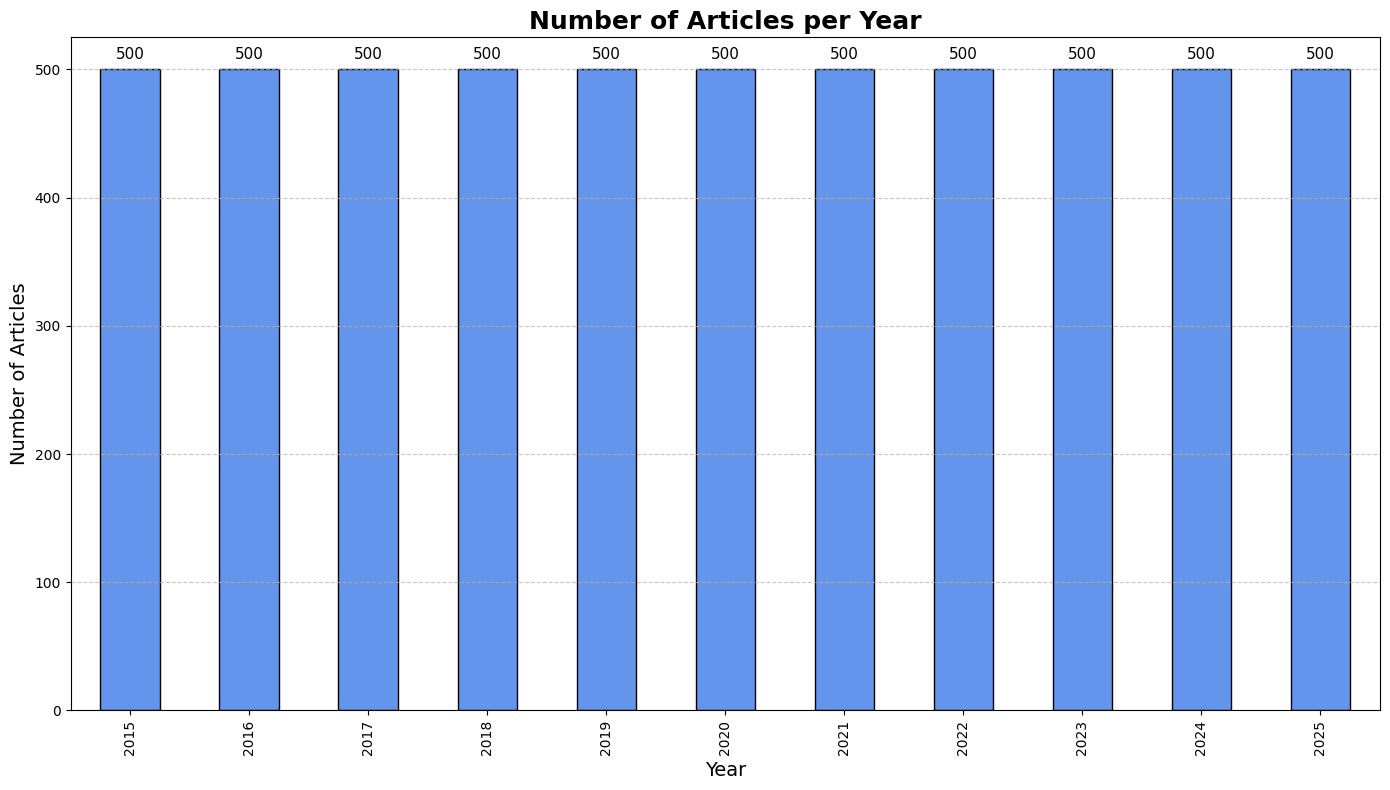

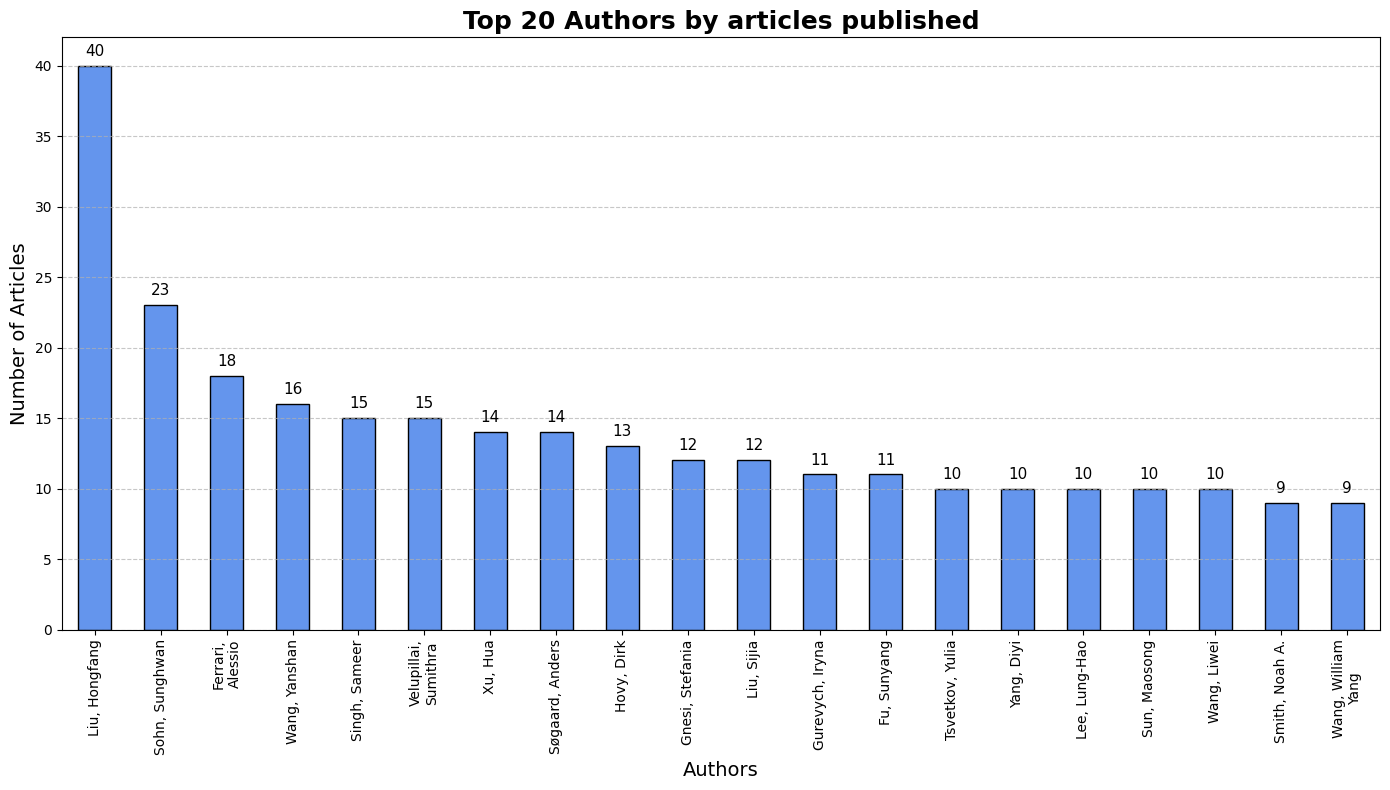

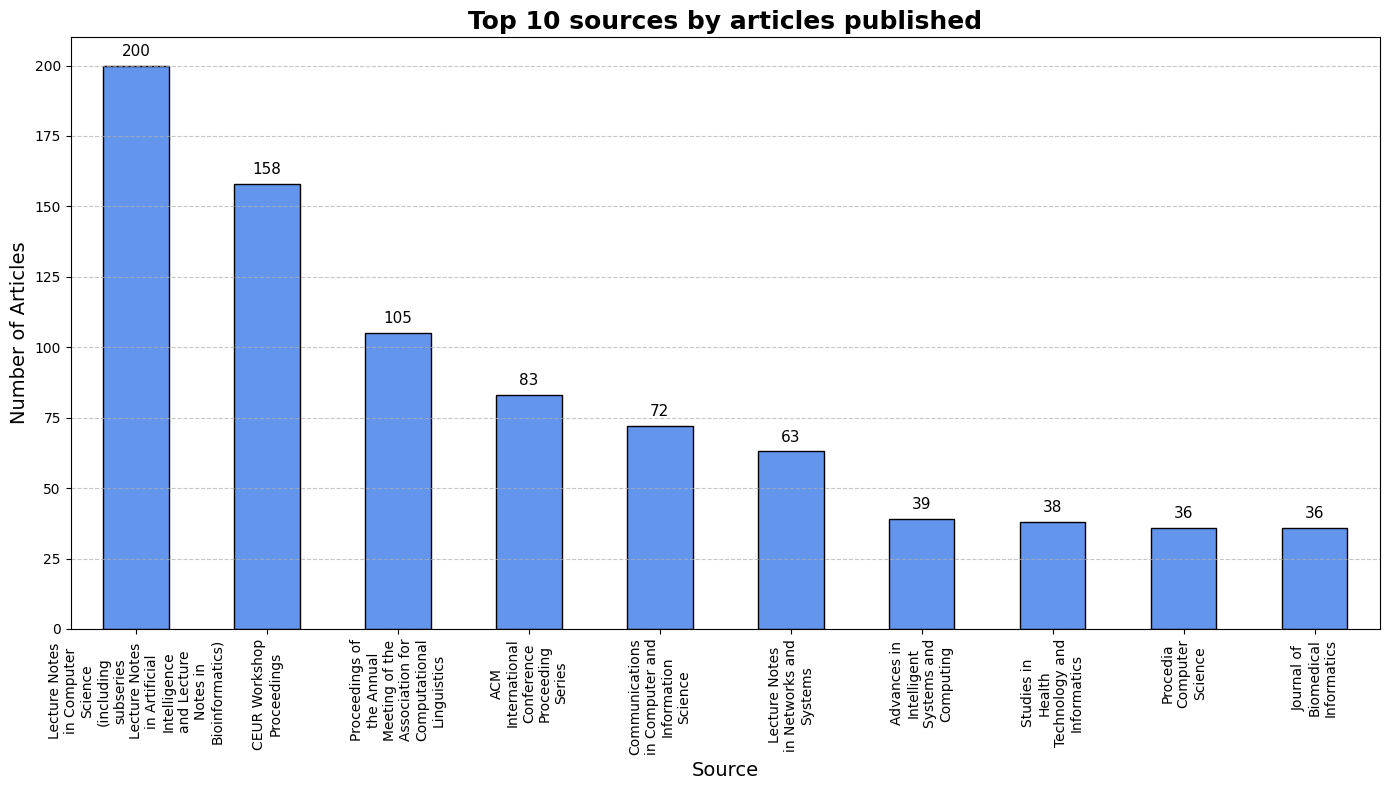

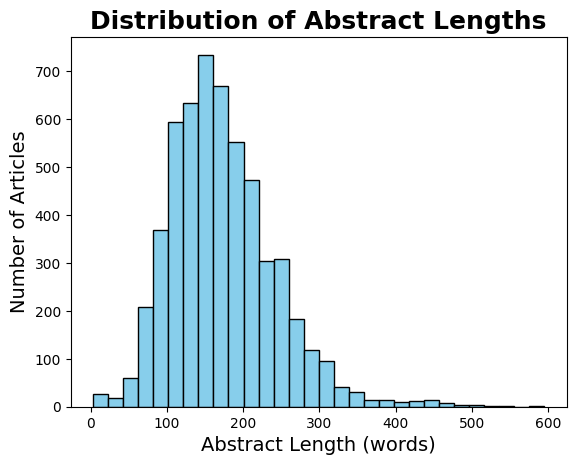

In [46]:
articles_per_year = articles_df['Year'].value_counts().sort_index()
create_bar_chart(articles_per_year, "Number of Articles per Year", "Year", "Number of Articles")
all_authors = articles_df['Author full names'].dropna().str.split(';').explode().str.strip()
all_authors = all_authors.str.replace(r'\s*\(.*?\)', '', regex=True)
top_authors = all_authors.value_counts().head(20)
create_bar_chart(top_authors, "Top 20 Authors by articles published", "Authors", "Number of Articles")

top_sources = articles_df['Source title'].value_counts().head(10)
create_bar_chart(top_sources, "Top 10 sources by articles published", "Source", "Number of Articles")

abstracts_lengths = articles_df['Abstract'].dropna().apply(lambda x: len(x.split()))
create_bins_chart(abstracts_lengths, "Distribution of Abstract Lengths", "Abstract Length (words)", "Number of Articles")

In [47]:
def combine_keywords(df):
    author_kws = df['Author Keywords'].fillna('').str.split(';')
    index_kws = df['Index Keywords'].fillna('').str.split(';')
    org_kws = df['Common_ORG_Entities'].fillna('').apply(lambda x: x if isinstance(x, list) else [])

    stop_keywords = {
        'man', 'woman', 'male', 'female', 'young adult', 'human', 'study',
        'method', 'algorithms', 'article', 'adult', 'simple++', 'humans', "'current"
    }

    combined_keywords = []

    for a_kws, i_kws, o_kws in zip(author_kws, index_kws, org_kws):
        kws = set()

        # Add author and index keywords
        if a_kws:
            kws.update([kw.strip().lower() for kw in a_kws if kw])
        if i_kws:
            kws.update([kw.strip().lower() for kw in i_kws if kw])

        # Add org-based NER keywords (already lowercased in earlier code)
        if o_kws:
            kws.update([kw.strip().lower() for kw in o_kws if kw])

        # Filter stop words
        kws = {kw for kw in kws if kw not in stop_keywords}
        combined_keywords.append(list(kws))

    return combined_keywords

In [48]:
articles_df['Combined Keywords'] = combine_keywords(articles_df)
articles_df.head(10)

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Link,Abstract,Author Keywords,Index Keywords,Combined Keywords,Common_ORG_Entities
0,Shankar V.; Parsana S.,"Shankar, Venkatesh (7102439832); Parsana, Sohi...",7102439832; 57200450074,An overview and empirical comparison of natura...,2022,Journal of the Academy of Marketing Science,https://www.scopus.com/inward/record.uri?eid=2...,With artificial intelligence permeating conver...,Artificial intelligence; Autoencoder; Machine ...,NaN,"[unstructured data, text analysis, autoencoder...",[nlp]
1,Chen K.; Meng Y.; Sun X.; Guo S.; Zhang T.; Li...,"Chen, Kangjie (57219735841); Meng, Yuxian (572...",57219735841; 57216617236; 57216611212; 5683490...,BADPRE: TASK-AGNOSTIC BACKDOOR ATTACKS TO PRE-...,2022,ICLR 2022 - 10th International Conference on L...,https://www.scopus.com/inward/record.uri?eid=2...,Pre-trained Natural Language Processing (NLP) ...,NaN,Backdoors; Down-stream; Foundation models; Key...,"[natural language processing systems, prior in...",[nlp]
2,Hemavathi U.; Medona A.C.V.,"Hemavathi, U. (57226555469); Medona, Ann C. V....",57226555469; 57226547686,AI-Based Interactive Agent for Health Care Usi...,2022,Lecture Notes in Networks and Systems,https://www.scopus.com/inward/record.uri?eid=2...,Artificial intelligence (AI)-based interactive...,Artificial intelligence; Deep learning; Health...,NaN,"[deep learning, ai, natural language processin...","[dl, ai, nlp]"
3,Bauer D.; Longley T.; Ma Y.; Wilson T.,"Bauer, Daniel (57197925699); Longley, Tom (574...",57197925699; 57425276200; 57286065200; 5805552...,NLP in Human Rights Research: Extracting Knowl...,2022,Proceedings of the 16th Linguistic Annotation ...,https://www.scopus.com/inward/record.uri?eid=2...,In this paper we explore the use of an NLP sys...,Applications; Ethics and Legal Issues; Informa...,Data mining; Knowledge graph; Law enforcement;...,"[system, legal issues, security forces, nlp, a...",[nlp]
4,Gessler L.,"Gessler, Luke (57219184334)",57219184334,Closing the NLP Gap: Documentary Linguistics a...,2022,COMPUTEL 2022 - 5th Workshop on the Use of Com...,https://www.scopus.com/inward/record.uri?eid=2...,"For decades, researchers in natural language p...",NaN,Application programs; Computational linguistic...,"[natural language processing systems, computat...",[nlp]
5,Zhao X.; Li L.; Wang Y.-X.,"Zhao, Xuandong (57552407600); Li, Lei (5609407...",57552407600; 56094074700; 58912060300,Distillation-Resistant Watermarking for Model ...,2022,Findings of the Association for Computational ...,https://www.scopus.com/inward/record.uri?eid=2...,How can we protect the intellectual property o...,NaN,Classification (of information); Computational...,"[natural language processing systems, computat...",[nlp]
6,Latha B.; Nivedha B.; Ranjanaa Y.,"Latha, B. (26643194000); Nivedha, B. (57202678...",26643194000; 57202678926; 58127747300,Visual Audio Summarization Based on NLP Models,2022,2022 1st International Conference on Computati...,https://www.scopus.com/inward/record.uri?eid=2...,Natural Language Processing (NLP) uses compute...,Abstractive; comparison; extractive; Natural L...,Visual languages; Abstractive; Audio summariza...,"[natural language processing systems, key patt...",[nlp]
7,Rajan A.; Salgaonkar A.,"Rajan, Annie (57215688946); Salgaonkar, Ambuja...",57215688946; 35485507600,Survey of NLP Resources in Low-Resource Langua...,2022,Lecture Notes in Networks and Systems,https://www.scopus.com/inward/record.uri?eid=2...,Research results in different subdomains of NL...,Konkani language; Natural language processing;...,NaN,"[konkani language, sindhi language, natural la...",[nlp]
8,Desai N.P.; Dabhi V.K.,"Desai, Nikita P. (26639236000); Dabhi, Vipul K...",26639236000; 24823939300,Resources and components for gujarati NLP syst...,2022,Artificial Intelligence Review,https://www.scopus.com/inward/record.uri?eid=2...,Natural Language Processing (NLP) represents t...,Components; Corpus; Gujarati; Indian language;...,

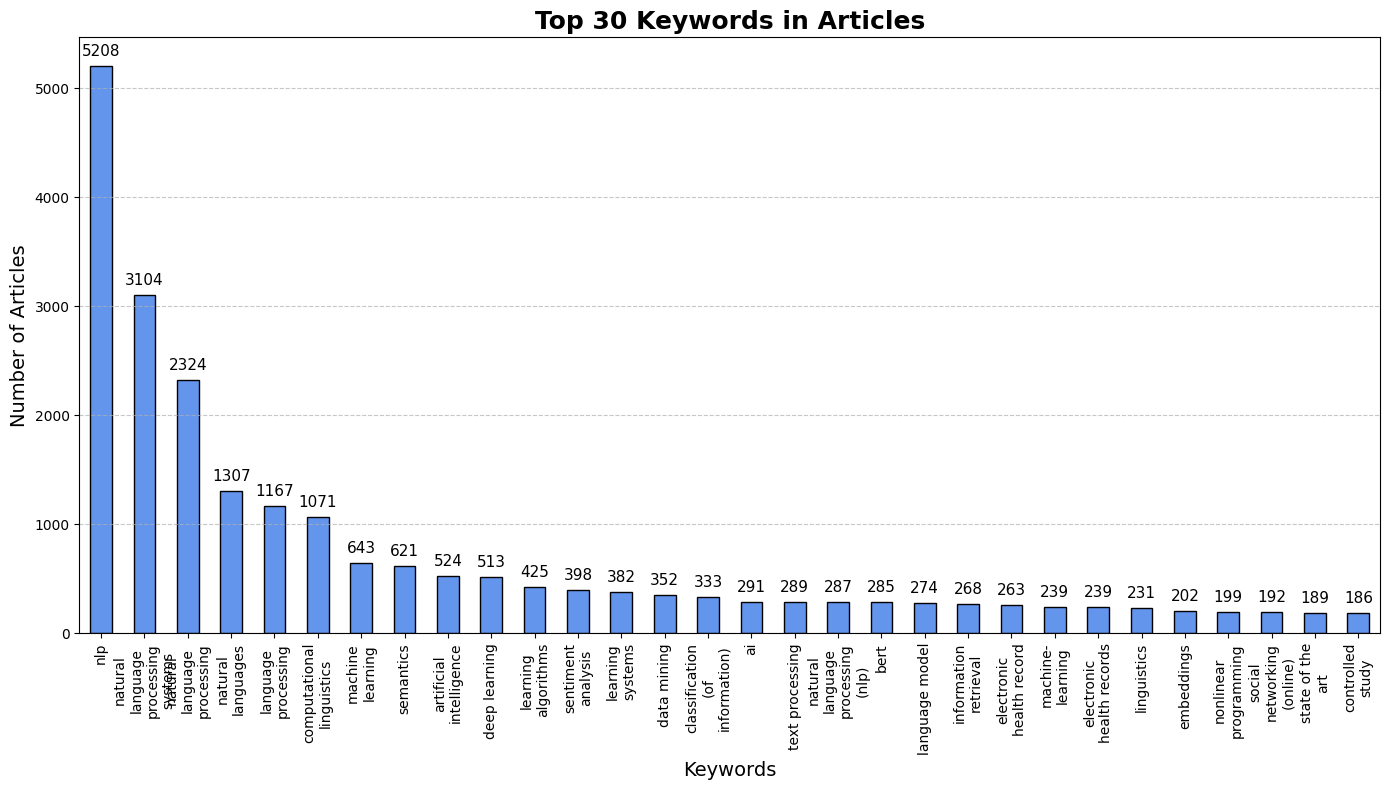

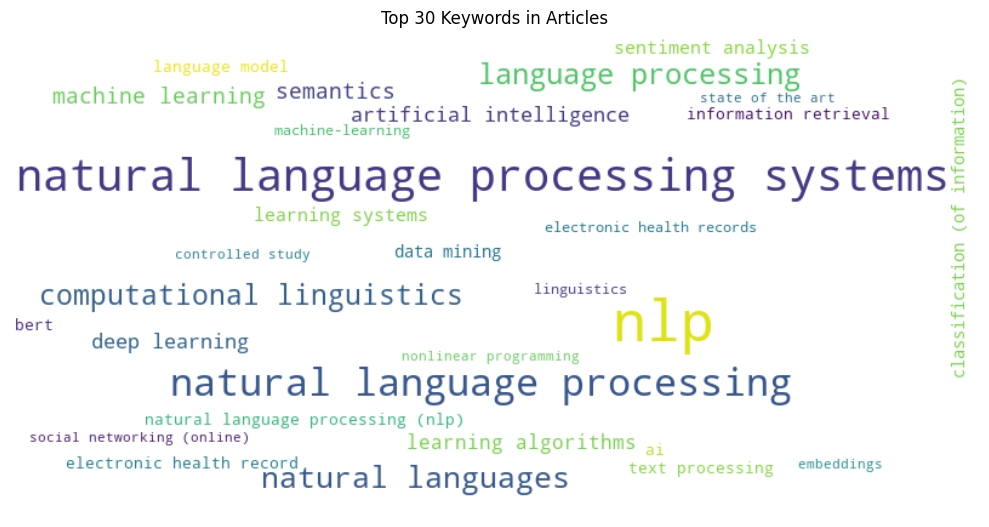

In [49]:
all_keywords = articles_df['Combined Keywords'].explode().dropna()
keyword_counts = all_keywords.value_counts().head(30)
create_bar_chart(keyword_counts, "Top 30 Keywords in Articles", "Keywords", "Number of Articles")
create_wordcloud(dict(keyword_counts), "Top 30 Keywords in Articles")

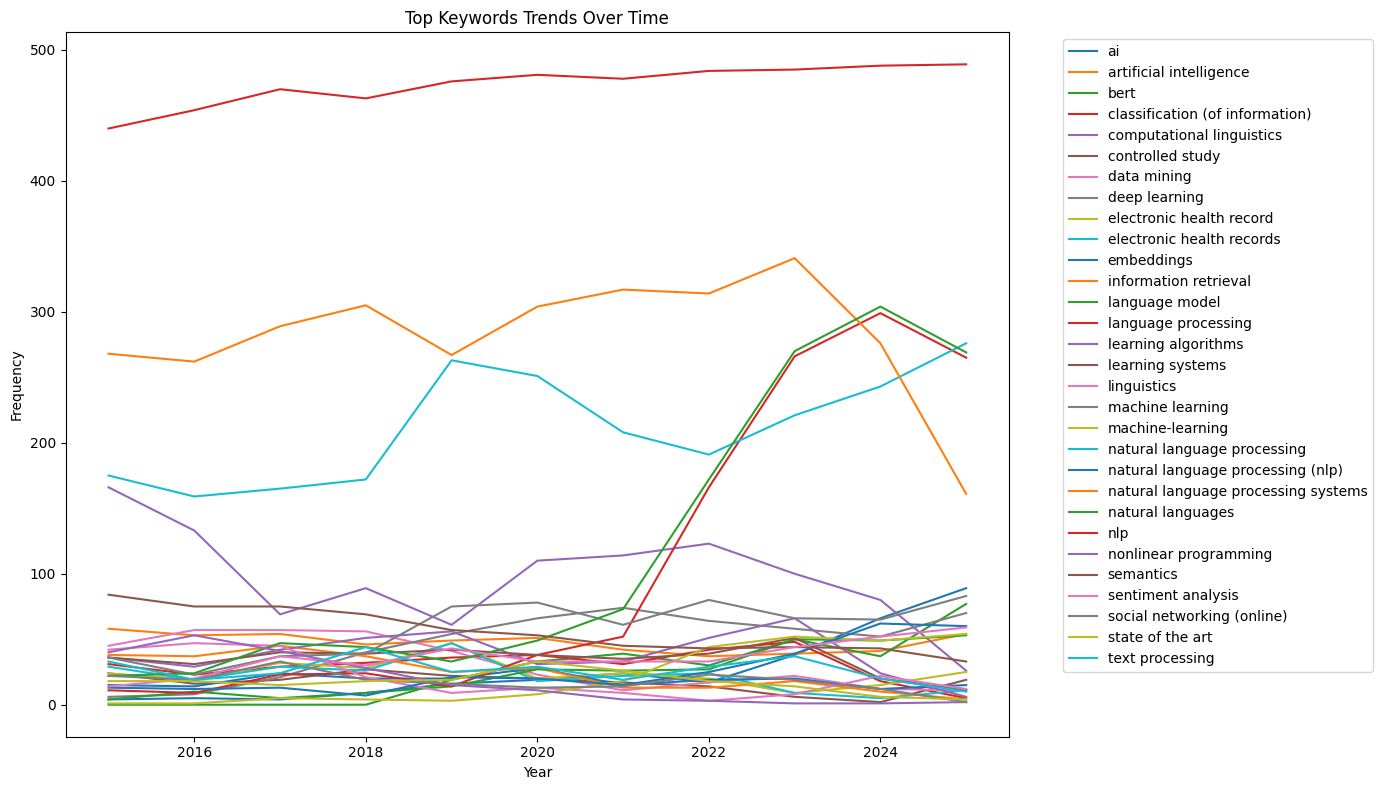

In [50]:
top_keywords = keyword_counts.index.tolist()[:30]

articles_df['Combined Keywords'] = articles_df['Combined Keywords'].apply(lambda x: [kw.strip().lower() for kw in x] if isinstance(x, list) else [])
keywords_year_df = articles_df.explode('Combined Keywords')

keywords_year_df = keywords_year_df[keywords_year_df['Combined Keywords'].isin(top_keywords)]

trend_data = (
    keywords_year_df.groupby(['Year', 'Combined Keywords'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(14, 8))
for keyword in trend_data.columns:
    plt.plot(trend_data.index, trend_data[keyword], label=keyword)

plt.title("Top Keywords Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [51]:
exploded_keywords_df = articles_df[['Combined Keywords']].explode('Combined Keywords')
exploded_keywords_df['Combined Keywords'] = exploded_keywords_df['Combined Keywords'].str.lower().str.strip()

binary_matrix = pd.crosstab(exploded_keywords_df.index, exploded_keywords_df['Combined Keywords'])
top_keywords = exploded_keywords_df['Combined Keywords'].value_counts().head(1000).index
filtered_matrix = binary_matrix[top_keywords]
correlation_matrix = filtered_matrix.corr(method='pearson')
# correlation_matrix = binary_matrix.corr(method='pearson')
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)


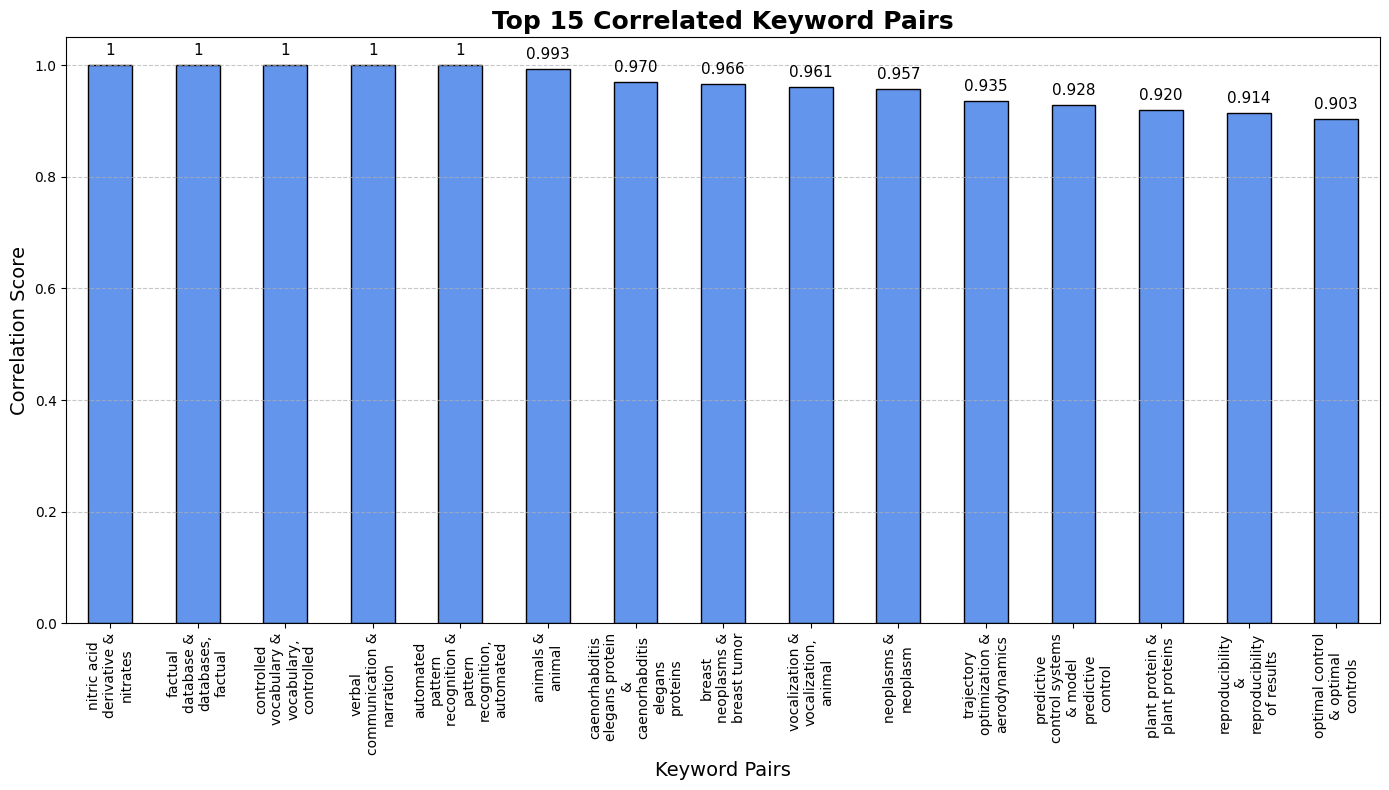

In [52]:
top_correlated_pairs = upper_triangle.stack().sort_values(ascending=False)

top_corr_pairs = top_correlated_pairs.head(15)

pair_labels = [f"{a} & {b}" for a, b in top_corr_pairs.index]
correlation_scores = top_corr_pairs.values

create_bar_chart(pd.Series(correlation_scores, index=pair_labels),
                  "Top 15 Correlated Keyword Pairs",
                    "Keyword Pairs", "Correlation Score")

In [53]:
keyword_year_df = articles_df[['Year', 'Combined Keywords']].explode('Combined Keywords')
keyword_year_df = keyword_year_df.dropna()

keyword_counts = keyword_year_df.groupby(['Combined Keywords', 'Year']).size().unstack(fill_value=0)

min_total_count = 30
total_counts = keyword_counts.sum(axis=1)
keyword_counts = keyword_counts[total_counts >= min_total_count]

z_scores = (keyword_counts - keyword_counts.mean(axis=1).values[:, None]) / keyword_counts.std(axis=1).values[:, None]
z_scores = z_scores.fillna(0)

top_z_keywords_per_year = {}
min_year_count = 10

for year in z_scores.columns:
    valid_keywords = keyword_counts[year] >= min_year_count
    filtered_z = z_scores[year][valid_keywords]
    top_keywords = filtered_z.sort_values(ascending=False).head(5)
    top_z_keywords_per_year[year] = top_keywords

keyword_only_dict = {
    year: list(keywords.index) for year, keywords in top_z_keywords_per_year.items()
}

trend_df_keywords = pd.DataFrame.from_dict(keyword_only_dict, orient='index')
trend_df_keywords.columns = [f"Place {i+1}" for i in range(trend_df_keywords.shape[1])]

display(trend_df_keywords)

,Place 1,Place 2,Place 3,Place 4,Place 5
2015,information science,electronic medical record,follow up,f,genetics
2016,ontology,optimal control systems,wordnet,optimization,acl
2017,education,software engineering,intelligent systems,social networking (online),acm
2018,recurrent neural networks,supervised learning,text processing,speech recognition,f
2019,diagnostic imaging,gold standard,electronic health record,algorithm,electronic health records
2020,human experiment,embeddings,question answering,state of the art,named entity recognition
2021,large-scales,covid-19,acm,transfer learning,surveys
2022,parts-of-speech tagging,text data,support vector machines,forecasting,text classification
2023,e-learning,human language,case-studies,digital storage,transformers
2024,adversarial machine learning,text analysis,language processing techniques,economic and social effects,data handling


In [41]:
top_keywords_per_year = (
    keyword_year_df
    .groupby(['Year', 'Combined Keywords'])
    .size()
    .reset_index(name='count')
    .sort_values(['Year', 'count'], ascending=[True, False])
)

print("\nMost frequent keywords per year:")
for year in sorted(keyword_year_df['Year'].unique()):
    year_keywords = top_keywords_per_year[top_keywords_per_year['Year'] == year].head(15)
    print(f"\n{year}:")
    for _, row in year_keywords.iterrows():
        print(f"{row['Combined Keywords']}: {row['count']}")


Most frequent keywords per year:

2015:
nlp: 440
natural language processing systems: 268
natural language processing: 187
computational linguistics: 166
semantics: 84
artificial intelligence: 58
data mining: 45
springer international publishing: 43
linguistics: 42
nonlinear programming: 40
information retrieval: 38
learning algorithms: 36
learning systems: 36
machine learning: 36
procedures: 35

2016:
nlp: 454
natural language processing systems: 262
natural language processing: 172
computational linguistics: 133
semantics: 75
data mining: 57
artificial intelligence: 53
nonlinear programming: 53
linguistics: 47
2016 association for computational linguistics: 44
information retrieval: 37
learning systems: 31
learning algorithms: 29
springer international publishing: 29
natural languages: 24

2017:
nlp: 470
natural language processing systems: 289
natural language processing: 183
semantics: 75
computational linguistics: 69
data mining: 57
artificial intelligence: 54
natural languages: 

In [21]:
summarizer = pipeline("summarization", model="t5-small")
def summarize_text(text):
    try:
        summary = summarizer("summarize: " + text, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return ""
SUM_N = 30
summarized_abstracts = [summarize_text(abstract) for abstract in abstracts[:SUM_N] if isinstance(abstract, str)]


KeyboardInterrupt: 

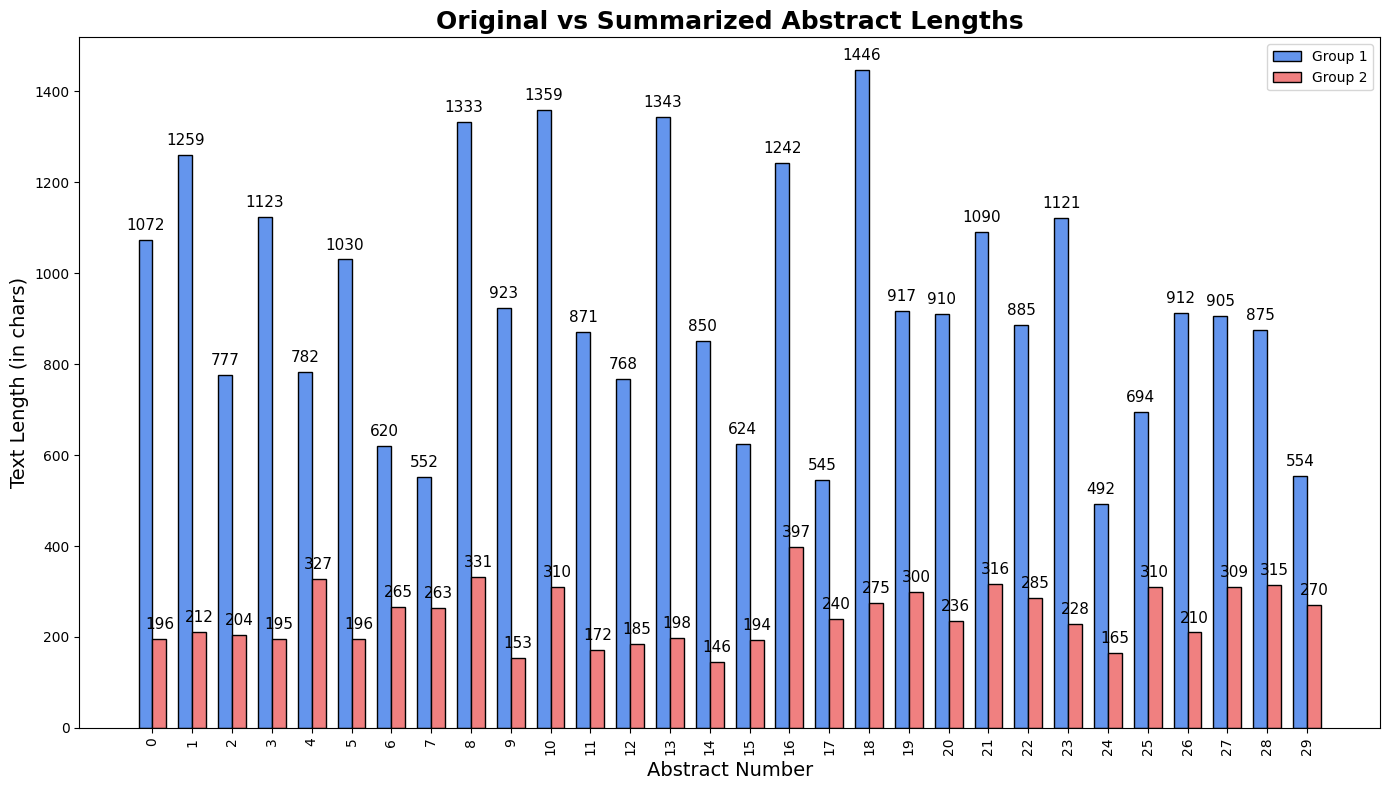

In [ ]:
original_lengths = [len(abstract) for abstract in abstracts[:SUM_N] if isinstance(abstract, str)]
summary_lengths = [len(summary) for summary in summarized_abstracts]

indices = range(len(original_lengths))

create_grouped_bar_chart(indices, original_lengths, summary_lengths,
                          "Original vs Summarized Abstract Lengths",
                            "Abstract Number", "Text Length (in chars)")

In [ ]:
# # summarize each year's abstracts
# import hf_xet
# summarizer = pipeline("summarization", model="Falconsai/text_summarization")  # handles longer input than T5-small
# # yearly_summaries = articles_df.groupby('Year')['Abstract'].apply(lambda x: ' '.join(x.dropna().tolist()))
# # yearly_summaries = yearly_summaries.reset_index()
# # yearly_summaries['Summary'] = yearly_summaries['Abstract'].apply(summarize_text)

# yearly_samples = (
#     articles_df.dropna(subset=["Abstract"])
#     .groupby("Year")["Abstract"]
#     .apply(lambda x: ' '.join(x.iloc[:10]))  # Join first 10 abstracts
#     .reset_index()
# )

# # Summarize each sample
# yearly_samples["Summary"] = yearly_samples["Abstract"].apply(summarize_text)
# for _, row in yearly_samples.iterrows():
#     print(f"\n🗓️ Year: {row['Year']}")
#     print(f"📄 Summary:\n{row['Summary']}")

In [ ]:
# from transformers import pipeline

# prompt = f"""
# You are an academic expert in Natural Language Processing (NLP). Write a comprehensive review article summarizing key research trends in NLP over the past decade (2015–2025).

# The following table lists the top trending keywords for each year, extracted from a corpus of 5,500 academic papers:

# {trend_df_keywords.to_string()}

# Using these keywords, write a detailed review discussing the evolution of topics in NLP research. Highlight shifts in focus, emerging technologies, and applications over the years.

# Make it readable and informative for NLP researchers.
# """


# # Set up a text-generation pipeline with a GPT-style model
# generator = pipeline(
#     "text2text-generation",
#     model='google/flan-t5-base',  # lightweight GPT-style model
# )

# # Your QA-style prompt
# def ask_question():
#     result = generator(prompt, max_length=200, do_sample=False)
#     return result[0]['generated_text']


# answer = ask_question()
# print("Answer:", answer)


In [ ]:
from transformers import pipeline
import pandas as pd

# Load the model
qa = pipeline("text2text-generation", model="google/flan-t5-base", device=-1)

# Dictionary to store yearly summaries
yearly_summaries = {}

# Iterate over each year in the DataFrame
for year in trend_df_keywords.index:
    keywords = trend_df_keywords.loc[year].dropna().tolist()
    keyword_str = ', '.join(keywords)

    prompt = f"""
Summarize the major research trends in Natural Language Processing (NLP) for the year {year}, based on the following top keywords:

{keyword_str}

Focus on what methods, technologies, and applications were most important in NLP that year. Write a short academic-style paragraph.
"""


    print(f"🧠 Summarizing NLP trends for: {year}")
    summary = qa(prompt.strip(), max_length=250)[0]['generated_text']
    yearly_summaries[year] = summary

# Display the results
print("\n📄 NLP Research Trends (Yearly Summaries)\n")
for year, text in yearly_summaries.items():
    print(f"### {year}\n{text}\n")


c:\NLP\Final-project\Project3\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--google--flan-t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
